# Book Recommendation

Machine Learning Final Project | Forough Mofidi | Spring 2024 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from IPython.display import display, Image, HTML
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")


## 1. Load Data

In [2]:
books=pd.read_csv('Books.csv')
ratings=pd.read_csv('Ratings.csv')
users=pd.read_csv('Users.csv')

In [3]:
books.shape, ratings.shape, users.shape

((271360, 8), (1149780, 3), (278858, 3))

In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


## 2. Data Preprocessing

In [7]:
print(books.duplicated().sum())
print(users.duplicated().sum())
print(ratings.duplicated().sum())

0
0
0


In [8]:
ratings['Book-Rating'].value_counts()

Book-Rating
0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: count, dtype: int64

In [9]:
# Remove ratings with 0
ratings = ratings[ratings['Book-Rating'] != 0]

In [10]:
ratings['Book-Rating'].value_counts()

Book-Rating
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: count, dtype: int64

In [11]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [12]:
ratings.shape

(433671, 3)

In [13]:
print("Any null values in Books:\n" ,books.isnull().sum())
print("Any null values in Ratings:\n ",ratings.isnull().sum())
print("Any null values in Users:\n",users.isnull().sum())

Any null values in Books:
 ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
Any null values in Ratings:
  User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
Any null values in Users:
 User-ID          0
Location         0
Age         110762
dtype: int64


In [14]:
# Merge users and ratings on User-ID
user_rating_df = ratings.merge(users, left_on = 'User-ID', right_on = 'User-ID')

In [15]:
user_rating_df

,User-ID,ISBN,Book-Rating,Location,Age
0,276726,0155061224,5,"seattle, washington, usa",NaN
1,276729,052165615X,3,"rijeka, n/a, croatia",16.0
2,276729,0521795028,6,"rijeka, n/a, croatia",16.0
3,276736,3257224281,8,"salzburg, salzburg, austria",NaN
4,276737,0600570967,6,"sydney, new south wales, australia",14.0
...,...,...,...,...,...
433666,276704,0806917695,5,"cedar park, texas, usa",NaN
433667,276704,1563526298,9,"cedar park, texas, usa",NaN
433668,276709,0515107662,10,"mannington, west virginia, usa",38.0
433669,276721,0590442449,10,"providence, rhode island, usa",14.0


In [16]:
# Merge user_rating_df and books on ISBN
book_user_rating  = user_rating_df.merge(books, left_on = 'ISBN', right_on = 'ISBN')
book_user_rating.head(5)

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276726,0155061224,5,"seattle, washington, usa",NaN,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,"rijeka, n/a, croatia",16.0,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,"rijeka, n/a, croatia",16.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
3,276744,038550120X,7,"torrance, california, usa",NaN,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...
4,276747,0060517794,9,"iowa city, iowa, usa",25.0,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...


In [17]:
book_user_rating.shape

(383842, 12)

In [18]:
# missing count on age 
missing_count = book_user_rating['Age'].isna().sum()
missing_count

114221

In [20]:
# drop unnecessary columns
book_user_rating.drop(['Image-URL-L', 'Image-URL-M', 'Age'], axis=1, inplace=True)

In [21]:
book_user_rating.shape

(383842, 9)

In [22]:
book_user_rating.head(5)

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
0,276726,0155061224,5,"seattle, washington, usa",Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,"rijeka, n/a, croatia",Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,"rijeka, n/a, croatia",The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...
3,276744,038550120X,7,"torrance, california, usa",A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...
4,276747,0060517794,9,"iowa city, iowa, usa",Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...


In [23]:
print("Any null values in Books:\n" ,book_user_rating.isnull().sum())

Any null values in Books:
 User-ID                0
ISBN                   0
Book-Rating            0
Location               0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
dtype: int64


In [24]:
book_user_rating = book_user_rating.dropna()

In [25]:
book_user_rating.shape

(383838, 9)

In [26]:
df=book_user_rating.copy()
df.shape

(383838, 9)

In [27]:
df

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
0,276726,0155061224,5,"seattle, washington, usa",Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,"rijeka, n/a, croatia",Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,"rijeka, n/a, croatia",The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...
3,276744,038550120X,7,"torrance, california, usa",A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...
4,276747,0060517794,9,"iowa city, iowa, usa",Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...
...,...,...,...,...,...,...,...,...,...
383837,276704,0743211383,7,"cedar park, texas, usa",Dreamcatcher,Stephen King,2001,Scribner,http://images.amazon.com/images/P/0743211383.0...
383838,276704,0806917695,5,"cedar park, texas, usa",Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997,Sterling Publishing,http://images.amazon.com/images/P/0806917695.0...
383839,276704,1563526298,9,"cedar park, texas, usa",Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...
383840,276709,0515107662,10,"mannington, west virginia, usa",The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,http://images.amazon.com/images/P/0515107662.0...


In [28]:
zero_count = df[df['Book-Rating'] == 0].shape[0]
zero_count

0

In [29]:
df=book_user_rating.copy()

# Clean book title, remove punctuation and special characters
df["Book-Title"]=df["Book-Title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())


In [30]:
df

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
0,276726,0155061224,5,"seattle, washington, usa",Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,"rijeka, n/a, croatia",Help Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,"rijeka, n/a, croatia",The Amsterdam Connection Level 4 Cambridge Eng...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...
3,276744,038550120X,7,"torrance, california, usa",A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...
4,276747,0060517794,9,"iowa city, iowa, usa",Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...
...,...,...,...,...,...,...,...,...,...
383837,276704,0743211383,7,"cedar park, texas, usa",Dreamcatcher,Stephen King,2001,Scribner,http://images.amazon.com/images/P/0743211383.0...
383838,276704,0806917695,5,"cedar park, texas, usa",Perplexing Lateral Thinking Puzzles Scholastic...,Paul Sloane,1997,Sterling Publishing,http://images.amazon.com/images/P/0806917695.0...
383839,276704,1563526298,9,"cedar park, texas, usa",Get Clark Smart The Ultimate Guide for the Sav...,Clark Howard,2000,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...
383840,276709,0515107662,10,"mannington, west virginia, usa",The Sherbrooke Bride Bride Trilogy Paperback,Catherine Coulter,1996,Jove Books,http://images.amazon.com/images/P/0515107662.0...


### Handling Multiple Rating Cases for each book

In [31]:
# Display list of unique books , multiple ratings
num_rating_df = df.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating': 'num_ratings'}, inplace=True)

sorted_num_rating_df = num_rating_df.sort_values(by='num_ratings', ascending=False)
sorted_num_rating_df.head(10)

,Book-Title,num_ratings
109465,The Lovely Bones A Novel,707
131333,Wild Animus,581
101988,The Da Vinci Code,494
115394,The Secret Life of Bees,406
111177,The Nanny Diaries A Novel,393
114167,The Red Tent Bestselling Backlist,383
29695,Divine Secrets of the Ya Ya Sisterhood A Novel,382
15580,Bridget Jones s Diary,377
2993,A Painted House,366
60282,Life of Pi,336


In [32]:
# Calculate the mean rating for each book 
avg_rating_df = df.groupby('Book-Title').agg({'Book-Rating': 'mean'}).reset_index()

# Rename 
avg_rating_df.rename(columns={'Book-Rating': 'avg_ratings'}, inplace=True)
#avg_rating_df.head(10)

# Sort 
sorted_avg_rating_df = avg_rating_df.sort_values(by='avg_ratings', ascending=False)
sorted_avg_rating_df.head(10)

,Book-Title,avg_ratings
0,006781 Bk 1 Gags De Boule Et Bil,10.0
89214,Simple Justice A Benjamin Justice Mystery Benj...,10.0
89301,Sin City That Yellow Bastard Sin City Series No 4,10.0
89300,Sin City Booze Broads amp Bullets,10.0
12948,Beyond the Birds and the Bees,10.0
12947,Beyond modern art,10.0
89294,Simulation A Problem Solving Approach,10.0
89292,Simulacra Faces and figures in nature,10.0
89282,Simply Vegan Quick Vegetarian Meals,10.0
89279,Simply Simpatico The Home of Authentic Southwe...,10.0


In [33]:
avg_rating_df.shape , df.shape

((134550, 2), (383838, 9))

## EDA

In [34]:
# What are the most reviewd books?
df.groupby("Book-Title").agg({"Book-Rating":"count"}).sort_values("Book-Rating", ascending=False).head(5) 

,Book-Rating
Book-Title,
The Lovely Bones A Novel,707
Wild Animus,581
The Da Vinci Code,494
The Secret Life of Bees,406
The Nanny Diaries A Novel,393


## 3. POPULARITY BASED RECOMMENDATION SYSTEM

In [35]:
# Step 1: Calculate average rating and count of ratings for each book
rating_info = df.groupby('Book-Title').agg({
    'Book-Rating': ['mean', 'count'] , 'Image-URL-S': 'first'}).reset_index()

# Renaming columns
rating_info.columns = ['Book-Title', 'Average-Rating', 'Rating-Count', 'Image-URL-S']

In [36]:
rating_info

,Book-Title,Average-Rating,Rating-Count,Image-URL-S
0,006781 Bk 1 Gags De Boule Et Bil,10.000000,1,http://images.amazon.com/images/P/2266022253.0...
1,01 01 00 A Novel of the Millennium,6.400000,5,http://images.amazon.com/images/P/0312870582.0...
2,01 01 00 The Novel of the Millennium,6.777778,9,http://images.amazon.com/images/P/0812568710.0...
3,03 NODDY AND HIS CAR,5.000000,1,http://images.amazon.com/images/P/0563368047.0...
4,08 15 Heute,7.000000,1,http://images.amazon.com/images/P/3442013453.0...
...,...,...,...,...
134545,Ã Â bernachten mit Stil Die schÃ Â nsten Count...,8.000000,1,http://images.amazon.com/images/P/3724303432.0...
134546,Ã Â rger mit Produkt X Roman,7.000000,3,http://images.amazon.com/images/P/325721538X.0...
134547,Ã Â sterlich leben,7.000000,1,http://images.amazon.com/images/P/3451274973.0...
134548,Ã Â stlich der Berge,8.000000,1,http://images.amazon.com/images/P/3442725739.0...


In [37]:
# Step 2: Filter books with a minimum number of ratings, e.g., books rated more than 10 times
min_rating_count = 15
popular_books = rating_info[rating_info['Rating-Count'] > min_rating_count]

In [38]:
popular_books

,Book-Title,Average-Rating,Rating-Count,Image-URL-S
47,10 Lb Penalty,7.350000,20,http://images.amazon.com/images/P/0515123471.0...
338,16 Lighthouse Road,7.294118,17,http://images.amazon.com/images/P/1551668300.0...
372,1984,8.768707,147,http://images.amazon.com/images/P/0451524934.0...
400,1st to Die A Novel,7.711864,236,http://images.amazon.com/images/P/0446610038.0...
446,2001 A Space Odyssey,8.666667,21,http://images.amazon.com/images/P/0451452739.0...
...,...,...,...,...
134358,Zodiac The Eco Thriller,8.000000,22,http://images.amazon.com/images/P/0553573861.0...
134406,Zoya,7.190476,21,http://images.amazon.com/images/P/0440203856.0...
134472,e,7.304348,23,http://images.amazon.com/images/P/0452281881.0...
134483,iI Paradiso Degli Orchi,7.647059,17,http://images.amazon.com/images/P/880781210X.0...


In [39]:
# Step 3: Sort the books by average rating and number of ratings
popular_books_sorted = popular_books.sort_values(by=['Average-Rating', 'Rating-Count'], ascending=False)
popular_books_sorted

,Book-Title,Average-Rating,Rating-Count,Image-URL-S
45045,Harry Potter and the Chamber of Secrets Postca...,9.869565,23,http://images.amazon.com/images/P/0439425220.0...
114330,The Return of the King The Lord of The Rings P...,9.625000,16,http://images.amazon.com/images/P/0618002243.0...
97643,The Authoritative Calvin and Hobbes Calvin and...,9.600000,20,http://images.amazon.com/images/P/0836218221.0...
17096,Calvin and Hobbes,9.583333,24,http://images.amazon.com/images/P/0836220889.0...
70404,My Sister s Keeper A Novel Picoult Jodi,9.545455,22,http://images.amazon.com/images/P/0743454529.0...
...,...,...,...,...
21681,Confessions of a Sociopathic Social Climber Th...,5.250000,20,http://images.amazon.com/images/P/0312288115.0...
47910,Hotel World,5.250000,16,http://images.amazon.com/images/P/0385722109.0...
20550,Coal A Human History,4.947368,19,http://images.amazon.com/images/P/0142000981.0...
115688,The Sexual Life of Catherine M,4.913043,23,http://images.amazon.com/images/P/1852428112.0...


In [40]:
# Step 4: get top 10 popular books
top_10_books = popular_books_sorted.head(10)
top_10_books

,Book-Title,Average-Rating,Rating-Count,Image-URL-S
45045,Harry Potter and the Chamber of Secrets Postca...,9.869565,23,http://images.amazon.com/images/P/0439425220.0...
114330,The Return of the King The Lord of The Rings P...,9.625000,16,http://images.amazon.com/images/P/0618002243.0...
97643,The Authoritative Calvin and Hobbes Calvin and...,9.600000,20,http://images.amazon.com/images/P/0836218221.0...
17096,Calvin and Hobbes,9.583333,24,http://images.amazon.com/images/P/0836220889.0...
70404,My Sister s Keeper A Novel Picoult Jodi,9.545455,22,http://images.amazon.com/images/P/0743454529.0...
776,52 Deck Series 52 Ways to Celebrate Friendship,9.500000,16,http://images.amazon.com/images/P/0811824829.0...
21363,Complete Chronicles of Narnia,9.444444,18,http://images.amazon.com/images/P/0066238501.0...
105307,The Giving Tree,9.423077,26,http://images.amazon.com/images/P/0060256664.0...
130480,Where the Sidewalk Ends Poems and Drawings,9.400000,25,http://images.amazon.com/images/P/0060256672.0...
68590,More Than Complete Hitchhiker s Guide,9.375000,16,http://images.amazon.com/images/P/0517693119.0...


In [41]:
from IPython.display import display, HTML

# Function to display top books with images and ratings in a single row
def display_top_books_in_row(n):
    top_books = popular_books_sorted.head(n)
    images_html = "".join(
        f'''
        <div style="display: inline-block; text-align: center; margin-right: 10px;">
            <img src="{row["Image-URL-S"]}" style="width: 100px; height: 150px;">
            <div style="color: grey; font-size: 12px;">Rating: {row["Average-Rating"]:.1f}</div>
        </div>
        '''
        for _, row in top_books.iterrows()
    )
    display(HTML(f'<div style="white-space: nowrap; overflow-x: auto;">{images_html}</div>'))

display_top_books_in_row(10)


## 4.User Based Collaborative Filtering

In [42]:
df['Book-Rating'].value_counts()

Book-Rating
8     91803
10    71224
7     66402
9     60776
5     45355
6     31687
4      7617
3      5118
2      2375
1      1481
Name: count, dtype: int64

In [43]:
df.head(2)

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
0,276726,0155061224,5,"seattle, washington, usa",Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,"rijeka, n/a, croatia",Help Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...


In [44]:
subset = df.sample(frac=0.4)
subset.shape

(153535, 9)

In [45]:
users_books_matrix = subset.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating', fill_value=0)

In [46]:
users_books_matrix

Book-Title,006781 Bk 1 Gags De Boule Et Bil,01 01 00 A Novel of the Millennium,01 01 00 The Novel of the Millennium,03 NODDY AND HIS CAR,08 15 Heute,1 000 More Jokes for Kids,1 000 Places to See Before You Die,1 000 Years 1 000 People Ranking the Men and Women Who Shaped the Millennium,1 001 Facts Somebody Screwed Up,1 001 Great Pet Jokes,...,Ã ngeles fugaces Falling Angels,Ã sucesso solo 50 anni fa Lo sterminio di sei milioni di Ebrei,Ã Â Kolumnen,Ã Â a,Ã Â ber den Wassern schweben,Ã Â ber die Pflicht zum Ungehorsam gegen den Staat,Ã Â berleben in der WÃ Â¼ste Danakil,Ã Â rger mit Produkt X Roman,Ã Â stlich der Berge,Ã Â thique en toc
User-ID,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Save and Load  Matrix


In [48]:
import pickle

# Save using pickle
# with open('users_books_matrix.pkl', 'wb') as file:
#     pickle.dump(users_books_matrix, file)

# Load using pickle
# with open('users_books_matrix.pkl', 'rb') as file:
#     loaded_matrix = pickle.load(file)

# print(loaded_matrix)

### Calculate User Similarity 

In [47]:
# Compute user similarity matrix
similarity_matrix = cosine_similarity(users_books_matrix)
similarity_matrix_df = pd.DataFrame(similarity_matrix, index=users_books_matrix.index, columns=users_books_matrix.index)


In [48]:
similarity_matrix_df.describe()

User-ID,8,12,14,16,17,26,39,53,82,85,...,278800,278818,278825,278831,278832,278843,278844,278851,278852,278854
count,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000,...,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000,39846.000000
mean,0.000041,0.000025,0.000025,0.000692,0.000099,0.001581,0.000101,0.000077,0.000025,0.000034,...,0.000647,0.000026,0.000063,0.000079,0.000133,0.001616,0.000602,0.000126,0.000062,0.000189
std,0.005538,0.005010,0.005010,0.023179,0.008299,0.029437,0.007948,0.007445,0.005010,0.005338,...,0.021091,0.005013,0.007491,0.006760,0.010130,0.020738,0.017582,0.007568,0.007278,0.009649
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
# Save the DF using pickle
#df.to_pickle('similarity_matrix_df.pkl')

# Load DF 
#similarity_matrix_df = pd.read_pickle('similarity_matrix_df.pkl')

In [49]:
def predict_ratings(user_id):
    # Get similarities for the given user to all other users
    user_similarities = similarity_matrix_df.loc[user_id]
    # Exclude the active user's own similarity
    user_similarities = user_similarities.drop(user_id)
    # Get ratings of other users
    other_user_ratings = users_books_matrix.drop(user_id)
    # Calculate the weighted average
    weighted_sum = np.dot(user_similarities, other_user_ratings)
    sum_of_weights = user_similarities.sum()
    predictions = weighted_sum / sum_of_weights
    return pd.Series(predictions, index=users_books_matrix.columns)


In [50]:
# Predict for a specific user
user_predictions = predict_ratings(8)
print(user_predictions)

Book-Title
006781 Bk 1 Gags De Boule Et Bil                      0.0
01 01 00 A Novel of the Millennium                    0.0
01 01 00 The Novel of the Millennium                  0.0
03 NODDY AND HIS CAR                                  0.0
08 15 Heute                                           0.0
                                                     ... 
Ã Â ber die Pflicht zum Ungehorsam gegen den Staat    0.0
Ã Â berleben in der WÃ Â¼ste Danakil                  0.0
Ã Â rger mit Produkt X Roman                          0.0
Ã Â stlich der Berge                                  0.0
Ã Â thique en toc                                     0.0
Length: 72023, dtype: float64


In [51]:
# Make Recommendations

def recommend_items(user_id, num_recommendations=5):
    user_predictions = predict_ratings(user_id)
    # Filter out items the user has already rated
    already_rated_items = users_books_matrix.loc[user_id][users_books_matrix.loc[user_id] > 0].index
    recommendations = user_predictions.drop(already_rated_items)
    return recommendations.nlargest(num_recommendations)


In [63]:
df

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
0,276726,0155061224,5,"seattle, washington, usa",Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,"rijeka, n/a, croatia",Help Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,"rijeka, n/a, croatia",The Amsterdam Connection Level 4 Cambridge Eng...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...
3,276744,038550120X,7,"torrance, california, usa",A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...
4,276747,0060517794,9,"iowa city, iowa, usa",Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...
...,...,...,...,...,...,...,...,...,...
383837,276704,0743211383,7,"cedar park, texas, usa",Dreamcatcher,Stephen King,2001,Scribner,http://images.amazon.com/images/P/0743211383.0...
383838,276704,0806917695,5,"cedar park, texas, usa",Perplexing Lateral Thinking Puzzles Scholastic...,Paul Sloane,1997,Sterling Publishing,http://images.amazon.com/images/P/0806917695.0...
383839,276704,1563526298,9,"cedar park, texas, usa",Get Clark Smart The Ultimate Guide for the Sav...,Clark Howard,2000,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...
383840,276709,0515107662,10,"mannington, west virginia, usa",The Sherbrooke Bride Bride Trilogy Paperback,Catherine Coulter,1996,Jove Books,http://images.amazon.com/images/P/0515107662.0...


In [65]:
# Example: Recommend 3 items for user
recommendations = recommend_items(276704, 3)
print(recommendations)

Book-Title
Divine Secrets of the Ya Ya Sisterhood A Novel    0.333956
Bag of Bones                                      0.258606
Black House                                       0.195314
dtype: float64


In [66]:
# Disply Image and Title of Recommended Books

# Fetching details from the main DataFrame
recommended_books = df[df['Book-Title'].isin(recommendations.index)].drop_duplicates('Book-Title')
recommended_books = recommended_books.set_index('Book-Title').loc[recommendations.index]  # Reorder to match recommendations
recommended_books['Predicted-Rating'] = recommendations.values  # Adding predicted ratings

# Generating HTML content for display
html_content = ''.join(
    f'''
    <div style="margin: 10px; padding: 10px; border: 1px solid #cccccc; display: inline-block; text-align: center;">
        <img src="{row["Image-URL-S"]}" style="width: 100px; height: 150px;"><br>
        <strong>{index}</strong><br>
        Predicted Rating: {row["Predicted-Rating"]:.1f}
    </div>
    '''
    for index, row in recommended_books.iterrows()
)

display(HTML(html_content))


### Another function 
New Function to consider cases where no rating is available

In [67]:
def predict_single_rating(user_id, item_id, user_item_matrix, similarity_matrix_df):
    # Check if the user and item exist in the matrix
    if item_id not in user_item_matrix.columns or user_id not in user_item_matrix.index:
        # return a default value
        return np.mean(user_item_matrix.mean())

    # Get similarities for the given user to all other users
    user_similarities = similarity_matrix_df.loc[user_id]

    # Exclude active user
    user_similarities = user_similarities.drop(user_id, errors='ignore')

    # Get ratings of other users for the specified item
    item_ratings = user_item_matrix[item_id]

    # Exclude ratings by the user themselves 
    filtered_ratings = item_ratings.drop(user_id, errors='ignore')
    filtered_similarities = user_similarities[filtered_ratings.index]

    # Calculate the weighted sum
    weighted_sum = np.dot(filtered_ratings, filtered_similarities)
    sum_of_weights = filtered_similarities.sum()

    # Handle division by zero
    if sum_of_weights == 0:
        # Return the user's average rating 
        return user_item_matrix.loc[user_id].mean() if user_id in user_item_matrix.index else np.mean(user_item_matrix.mean())

    # Compute the predicted rating
    predicted_rating = weighted_sum / sum_of_weights
    return predicted_rating

In [167]:
# Example usage:
user_id = 276704
item_id = 'Rites of Passage'
predicted_rating = predict_single_rating(user_id, item_id, users_books_matrix, similarity_matrix_df)
print(f"Predicted Rating for user {user_id} and item {item_id}: {predicted_rating}")


Predicted Rating for user 276704 and item Rites of Passage: 0.0004076501495198428


### Evaluation - Surprise Package

In [70]:
#evaluation method

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

# Load data into Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['User-ID', 'Book-Title', 'Book-Rating']], reader)


In [71]:
trainset, testset = train_test_split(data, test_size=0.25)

In [72]:
# Use the SVD algorithm
algo = SVD()
algo.fit(trainset)

In [73]:
# Predictions on the testset
predictions = algo.test(testset)

# Evaluate accuracy
accuracy.rmse(predictions)

RMSE: 3.2067


3.2067216400624092

In [74]:
# Run 5-fold cross-validation 
cross_v = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cross_v

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.2123  3.2017  3.2111  3.2091  3.2054  3.2079  0.0039  
MAE (testset)     2.7947  2.7826  2.7898  2.7898  2.7842  2.7882  0.0044  
Fit time          2.90    2.71    2.88    2.76    2.88    2.83    0.08    
Test time         0.40    0.17    0.18    0.17    0.17    0.22    0.09    


{'test_rmse': array([3.21226683, 3.20167854, 3.21107475, 3.20912645, 3.20544446]),
 'test_mae': array([2.79472638, 2.78261041, 2.7897546 , 2.78977609, 2.78417111]),
 'fit_time': (2.897961139678955,
  2.7105958461761475,
  2.8773269653320312,
  2.760617971420288,
  2.883242130279541),
 'test_time': (0.4017000198364258,
  0.16862201690673828,
  0.18483304977416992,
  0.16698908805847168,
  0.16896677017211914)}

A RMSE of about 3.21 means that the standard deviation of the prediction errors is around 3.21. This indicates how much the predictions deviate from the actual values on average in terms of the units of the rating scale. It doesn’t mean each prediction is off by 3.21, but rather that the spread of errors tends to be around this value.
Mean Absolute Error (MAE): MAE provides a simpler interpretation. With an average MAE of about 2.79, this means that on average, the absolute difference between the predicted ratings and the actual ratings is about 2.79. This is a more direct measurement of average error per prediction, without considering the direction of the error (over or under-predicting).

## 5.Item Based Collaborative Filtering

In [75]:
df.head(2)

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
0,276726,0155061224,5,"seattle, washington, usa",Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,"rijeka, n/a, croatia",Help Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...


In [76]:
# 200 threshold specifying users who have provided more than 200 book ratings

x = df.groupby('User-ID').count()['Book-Rating']>200
knowledgable_users = x[x].index

In [77]:
knowledgable_users

Index([  4385,   6251,   6575,   7346,  11676,  13552,  16634,  16795,  23768,
        23872,
       ...
       257204, 258185, 261829, 262998, 264321, 265115, 265889, 269566, 270713,
       274061],
      dtype='int64', name='User-ID', length=118)

In [78]:
len(knowledgable_users)

118

In [79]:
filtered_rating = df[df['User-ID'].isin(knowledgable_users)]
filtered_rating.shape

(58171, 9)

In [80]:
# users who provided more than 200 reviews 
filtered_rating

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
6859,4385,0061083402,10,"albq, new mexico, usa",The Bandit s Lady Harper Monogram,Maureen Child,1995,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0061083402.0...
6860,4385,0061093343,9,"albq, new mexico, usa",Fault Lines,Anne Rivers Siddons,1996,HarperTorch,http://images.amazon.com/images/P/0061093343.0...
6861,4385,0061096156,10,"albq, new mexico, usa",Society of the Mind A Cyberthriller,Eric L. Harry,1997,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0061096156.0...
6862,4385,0312956762,10,"albq, new mexico, usa",Die Hard With a Vengeance A Novel,D. Chiel,1995,St Martins Pr,http://images.amazon.com/images/P/0312956762.0...
6863,4385,0312980353,10,"albq, new mexico, usa",Circle of Stars,Anna Lee Waldo,2002,St. Martin's Paperbacks,http://images.amazon.com/images/P/0312980353.0...
...,...,...,...,...,...,...,...,...,...
380865,274061,1892213737,10,"gahanna/columbus, ohio, usa",Cardcaptor Sakura Number 5,Clamp,2001,Tokyopop,http://images.amazon.com/images/P/1892213737.0...
380866,274061,189221394X,10,"gahanna/columbus, ohio, usa",Clover 2,Clamp,2001,Tokyopop,http://images.amazon.com/images/P/189221394X.0...
380867,274061,1892213958,10,"gahanna/columbus, ohio, usa",Clover 3,Clamp,2002,Tokyopop,http://images.amazon.com/images/P/1892213958.0...
380868,274061,1892213966,10,"gahanna/columbus, ohio, usa",Clover Clover 4,Clamp,2002,TokyoPop,http://images.amazon.com/images/P/1892213966.0...


In [81]:
# filtering for famous books , those items that have rating count of more than 10 
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=10
famous_books = y[y].index

In [82]:
print(filtered_rating['Book-Title'].dtype)
print(famous_books.dtype)


object
object


In [83]:
len(y)

41479

In [84]:
y

Book-Title
01 01 00 A Novel of the Millennium                                                                                                   False
01 01 00 The Novel of the Millennium                                                                                                 False
1 000 Makers of the Millennium The Men and Women Who Have Shaped the Last 1 000 Years                                                False
1 001 Old Time Garden Tips Timeless Bits of Wisdom on How to Grow Everything Organically from the Good Old Days When Everyone Did    False
1 003 Great Things About Kids                                                                                                        False
                                                                                                                                     ...  
wet sand raven tracks                                                                                                                False
whataboutrick co

In [85]:
famous_books

Index(['1984', '1st to Die A Novel', '2nd Chance', '84 Charing Cross Road',
       'A Bend in the Road', 'A Painted House', 'A Prayer for Owen Meany',
       'A Time to Kill', 'A Walk to Remember', 'A Wrinkle In Time',
       ...
       'Violets Are Blue', 'Watchers', 'Watership Down', 'When the Wind Blows',
       'Where Are the Children', 'Whispers', 'White Oleander A Novel',
       'Wicked The Life and Times of the Wicked Witch of the West',
       'Wizard and Glass The Dark Tower Book 4',
       'Zen and the Art of Motorcycle Maintenance An Inquiry into Values'],
      dtype='object', name='Book-Title', length=171)

In [86]:
final_ratings =  filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]

In [87]:
# Item_ Based - Rating count of 10 and more ; 
final_ratings

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
7005,4385,0440221471,10,"albq, new mexico, usa",The Runaway Jury,JOHN GRISHAM,1997,Dell,http://images.amazon.com/images/P/0440221471.0...
8619,6251,0060392452,10,"wahiawa, hawaii, usa",Stupid White Men and Other Sorry Excuses for t...,Michael Moore,2002,Regan Books,http://images.amazon.com/images/P/0060392452.0...
8622,6251,0061009059,7,"wahiawa, hawaii, usa",One for the Money Stephanie Plum Novels Paperback,Janet Evanovich,1995,HarperTorch,http://images.amazon.com/images/P/0061009059.0...
8633,6251,0140328696,9,"wahiawa, hawaii, usa",Charlie and the Chocolate Factory,Roald Dahl,1994,Puffin Books,http://images.amazon.com/images/P/0140328696.0...
8650,6251,0312980140,7,"wahiawa, hawaii, usa",Seven Up A Stephanie Plum Novel,Janet Evanovich,2002,St. Martin's Paperbacks,http://images.amazon.com/images/P/0312980140.0...
...,...,...,...,...,...,...,...,...,...
380798,274061,067082982X,10,"gahanna/columbus, ohio, usa",The Dark Half,Stephen King,1992,Viking Books,http://images.amazon.com/images/P/067082982X.0...
380799,274061,0670835382,10,"gahanna/columbus, ohio, usa",Four Past Midnight,Stephen King,1990,Viking Books,http://images.amazon.com/images/P/0670835382.0...
380801,274061,0670855030,10,"gahanna/columbus, ohio, usa",Insomnia,Stephen King,1994,Viking Books,http://images.amazon.com/images/P/0670855030.0...
380814,274061,0743211383,10,"gahanna/columbus, ohio, usa",Dreamcatcher,Stephen King,2001,Scribner,http://images.amazon.com/images/P/0743211383.0...


In [88]:
pt = final_ratings.pivot_table(index='Book-Title',columns='User-ID'
                          ,values='Book-Rating')
pt

User-ID,4385,6251,6575,7346,11676,13552,16634,16795,23768,23872,...,254899,257204,258185,261829,264321,265115,265889,269566,270713,274061
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,NaN,NaN,NaN,8.0,10.000000,NaN,NaN,8.0,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1st to Die A Novel,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,NaN,NaN,NaN,7.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.5,NaN,NaN,NaN,NaN,NaN,NaN
84 Charing Cross Road,NaN,NaN,NaN,NaN,8.333333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,NaN,NaN,1.0,NaN,6.500000,NaN,NaN,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whispers,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
White Oleander A Novel,NaN,8.0,NaN,NaN,9.000000,NaN,NaN,8.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wicked The Life and Times of the Wicked Witch of the West,NaN,NaN,9.0,7.0,9.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
pt.sample(5)

User-ID,4385,6251,6575,7346,11676,13552,16634,16795,23768,23872,...,254899,257204,258185,261829,264321,265115,265889,269566,270713,274061
Book-Title,,,,,,,,,,,,,,,,,,,,,
Key of Valor Roberts Nora Key Trilogy 3,0.0,0.0,0.0,0.0,10.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
Jurassic Park,0.0,0.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
The Chamber,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
It,0.0,0.0,0.0,0.0,8.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
Birthright,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
pt.fillna(0,inplace=True)
pt

User-ID,4385,6251,6575,7346,11676,13552,16634,16795,23768,23872,...,254899,257204,258185,261829,264321,265115,265889,269566,270713,274061
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,8.0,10.000000,0.0,0.0,8.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die A Novel,0.0,0.0,0.0,0.0,9.000000,0.0,0.0,9.0,0.0,0.0,...,0.0,0.0,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,7.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,8.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,1.0,0.0,6.500000,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whispers,0.0,0.0,0.0,0.0,7.000000,0.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
White Oleander A Novel,0.0,8.0,0.0,0.0,9.000000,0.0,0.0,8.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wicked The Life and Times of the Wicked Witch of the West,0.0,0.0,9.0,7.0,9.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
similarity_score = cosine_similarity(pt)
similarity_score.shape

(171, 171)

In [91]:
def recommend(book_name):
    index = np.where(pt.index==book_name)[0][0]
    similar_books = sorted(list(enumerate(similarity_score[index])),key=lambda x:x[1], reverse=True)[1:6]
    
    data = []
    
    for i in similar_books:
        item = []
        temp_df = books[books['Book-Title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
        
        data.append(item)
    return data

In [92]:
recommend("Message in a Bottle")

[[],
 ['A Walk to Remember',
  'Nicholas Sparks',
  'http://images.amazon.com/images/P/0446608955.01.MZZZZZZZ.jpg'],
 ['The Notebook',
  'Nicholas Sparks',
  'http://images.amazon.com/images/P/0446605239.01.MZZZZZZZ.jpg'],
 ['All I Really Need to Know',
  'ROBERT FULGHUM',
  'http://images.amazon.com/images/P/080410526X.01.MZZZZZZZ.jpg'],
 ['Dolores Claiborne',
  'Stephen King',
  'http://images.amazon.com/images/P/0451177096.01.MZZZZZZZ.jpg']]

In [93]:
#from IPython.display import display, HTML

def recommend(book_name, pt, books, similarity_score):
    # Get the index of the book
    try:
        index = np.where(pt.index == book_name)[0][0]
    except IndexError:
        print(f"No data available for the book: {book_name}")
        return
    
    # Find similar books based on the similarity score, ignoring the first because it is the book itself
    similar_books = sorted(list(enumerate(similarity_score[index])), key=lambda x: x[1], reverse=True)[1:6]

    # Prepare HTML content to display recommended books with images
    html_content = ''
    for i, _ in similar_books:
        book_title = pt.index[i]
        # Fetch the book details, ensuring the DataFrame is not empty
        temp_df = books[books['Book-Title'] == book_title].drop_duplicates('Book-Title')
        if temp_df.empty:
            print(f"No details found for recommended book: {book_title}")
            continue
        temp_df = temp_df.iloc[0]
        book_author = temp_df['Book-Author']
        book_image = temp_df['Image-URL-M']

        html_content += f'''
        <div style="margin: 10px; padding: 10px; border: 1px solid #cccccc; display: inline-block; text-align: center;">
            <img src="{book_image}" style="width: 100px; height: 150px;"><br>
            <strong>{book_title}</strong><br>
            Author: {book_author}
        </div>
        '''

    # Display the HTML content with book details and images, if any
    if html_content:
        display(HTML(html_content))
    else:
        print("No recommendations to display based on the input book.")


In [94]:

# Usage
recommend('A Walk to Remember', pt, books, similarity_score)

In [95]:

recommend('The Notebook', pt, books, similarity_score)

No details found for recommended book: Tuesdays with Morrie An Old Man a Young Man and Life s Greatest Lesson


In [101]:

recommend('1984', pt, books, similarity_score)

No details found for recommended book: The Hours A Novel
No details found for recommended book: The Hitchhiker s Guide to the Galaxy
No details found for recommended book: The Bonesetter s Daughter


In [103]:
recommend('Whispers', pt, books, similarity_score)

In [111]:
recommend('Jurassic Park', pt, books, similarity_score)

No details found for recommended book: Nightmares amp Dreamscapes


### Evaluation -Surprise

In [96]:
#evaluation method

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

# Load data into Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(final_ratings[['User-ID', 'Book-Title', 'Book-Rating']], reader)

In [97]:
trainset_IB, testset_IB = train_test_split(data, test_size=0.25)

In [98]:
# Use the SVD algorithm
algo = SVD()
algo.fit(trainset_IB)

In [99]:
# Predictions on the testset
predictions_IB = algo.test(testset_IB)

# Evaluate accuracy
accuracy.rmse(predictions_IB)

RMSE: 3.4858


3.485776593586115

In [100]:
# Item_Based Run 5-fold cross-validation 
cross_v = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cross_v

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.4554  3.6344  3.6111  3.5324  3.4960  3.5459  0.0677  
MAE (testset)     3.0370  3.2366  3.2068  3.1188  3.0920  3.1382  0.0737  
Fit time          0.02    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([3.4554182 , 3.63439767, 3.61113247, 3.5323616 , 3.49599394]),
 'test_mae': array([3.03698942, 3.23657804, 3.20683909, 3.11884108, 3.09196336]),
 'fit_time': (0.01577281951904297,
  0.011399030685424805,
  0.009680032730102539,
  0.008704900741577148,
  0.008105039596557617),
 'test_time': (0.0012750625610351562,
  0.0009860992431640625,
  0.0009150505065917969,
  0.0007989406585693359,
  0.0007407665252685547)}

## 6. Genre Prediction

In [113]:
from gensim.models import Word2Vec
import swifter


In [114]:
# Define genres and corresponding labels
genres = ['Fiction', 'Novel', 'Adventure', 'Romance', 'History', 'Thriller', 'Horror', 'Biography', 'Fantasy', 'Other']

In [115]:
sentences = [title.split() for title in df['Book-Title']]

# Train the Word2Vec model
model = Word2Vec(sentences, vector_size=500, window=5, min_count=5, sg=2)

In [116]:
# Define function to clean text
def clean_text(text):
    # Removes special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

In [117]:
# Define function to predict genre from book title
def predict_genre(book_title):
    clean_title =   clean_text(book_title)
    title_words = clean_title.split()

    # Check if title_words is empty
    if not title_words:
        return 'Other'

    # Filter title words that are present in the Word2Vec model vocabulary
    title_words = [word for word in title_words if word in model.wv]

    # Check if there are words left after filtering
    if not title_words:
        return 'Other'

    # Get the average word vector for the title , represents the semantic meaning of the title
    title_vector = sum([model.wv[word] for word in title_words]) / len(title_words)

    # Find the most similar genre based on cosine similarity
    most_similar_genre = None # Initial genre
    max_similarity = -1
    for genre in genres:
        genre_vector = model.wv[genre]
        similarity = cosine_similarity([title_vector], [genre_vector])[0][0] 
        if similarity > max_similarity:
            max_similarity = similarity
            most_similar_genre = genre

    return most_similar_genre

In [118]:
# Testing
book_title_to_predict = "Wie man einen Mann aufreisst (Heyne BÃ¼cher)"
predicted_genre = predict_genre(book_title_to_predict) # Genre predict of the book

print(f"The predicted genre for '{book_title_to_predict}' is {predicted_genre}.")

The predicted genre for 'Wie man einen Mann aufreisst (Heyne BÃ¼cher)' is Thriller.


In [119]:
df.head()

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
0,276726,0155061224,5,"seattle, washington, usa",Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,"rijeka, n/a, croatia",Help Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,"rijeka, n/a, croatia",The Amsterdam Connection Level 4 Cambridge Eng...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...
3,276744,038550120X,7,"torrance, california, usa",A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...
4,276747,0060517794,9,"iowa city, iowa, usa",Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...


In [120]:
# Applied function using swifter
df['Genre'] = df['Book-Title'].swifter.apply(predict_genre)

Pandas Apply:   0%|          | 0/383838 [00:00<?, ?it/s]

In [121]:
df.shape

(383838, 10)

In [122]:
df.sample(10)

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Genre
323881,232131,0399149759,8,"oakland, california, usa",Flashback,Nevada Barr,2003,Putnam Publishing Group,http://images.amazon.com/images/P/0399149759.0...,Other
359543,257090,0451179803,8,"richland, washington, usa",Spandau Phoenix,Greg Iles,1994,Signet Book,http://images.amazon.com/images/P/0451179803.0...,Other
284630,202036,0821774042,3,"port washington, new york, usa",The Fontainebleau Fan Zebra Regency Romance,Victoria Hinshaw,2002,Zebra Books,http://images.amazon.com/images/P/0821774042.0...,Adventure
253788,178478,0373292163,7,"chalk river, ontario, canada",An Honorable Thief Harlequin Historical No 616,Anne Gracie,2002,Harlequin,http://images.amazon.com/images/P/0373292163.0...,Romance
262005,184506,1591299829,10,"woodbury, connecticut, usa",The Works of the Flesh,R. Troyan Krause,2002,PublishAmerica,http://images.amazon.com/images/P/1591299829.0...,History
71217,46443,0590409212,7,"asheville, north carolina, usa",The Haunting of Grade Three Lucky Star,Grace Maccarone,1987,Scholastic Paperbacks,http://images.amazon.com/images/P/0590409212.0...,History
167843,113662,0380796090,8,"fairbanks, alaska, usa",Watermelon,Marian Keyes,1999,Avon,http://images.amazon.com/images/P/0380796090.0...,Other
66108,41911,0451456408,7,"iasi, n/a, romania",Crystal Sage,Kara Dalkey,1999,Roc,http://images.amazon.com/images/P/0451456408.0...,Other
322603,231210,0895945177,10,"roanoke, virginia, usa",On Women Turning Forty Coming into Our Fullness,Cathleen Rountree,1991,Crossing Press,http://images.amazon.com/images/P/0895945177.0...,Adventure
160215,107889,0020418809,10,"davenport, iowa, usa",CADDIE WOODLAWN,Carol Ryrie Brink,1970,Simon Pulse,http://images.amazon.com/images/P/0020418809.0...,Other


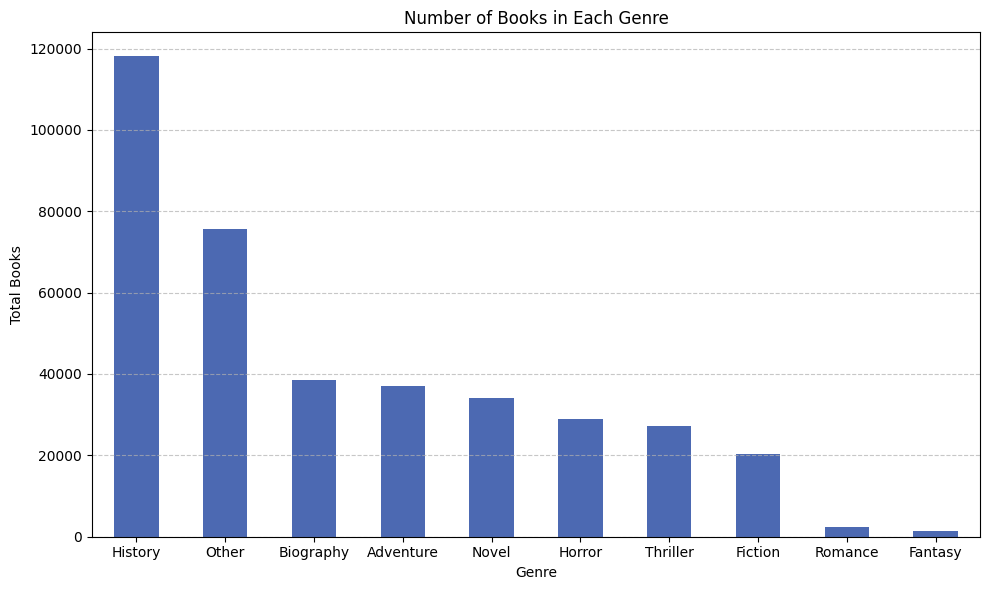

In [123]:
# Genre Visualization

genre_counts = df['Genre'].value_counts()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='#4c69b2')
plt.title('Number of Books in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Total Books')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 7. Content Based - Using LLM
Experiment on 100 book title due to token limits

In [124]:
# select 100 book title where rating is between 6-10    

df_cb = df[(df['Book-Rating'] >= 6) & (df['Book-Rating'] <= 10)].sample(100)
#df_cb


In [125]:

book_titles_100 = df_cb['Book-Title'].tolist()

In [126]:
len(book_titles_100)

100

In [127]:
book_titles_100

['Navy Wife Silhouette Romance',
 'The Adventures of Tom Sawyer',
 'Welshman S Way Harlequin Historical No 295',
 'Revolution from Within A Book of Self Esteem',
 'The Hitchhiker s Guide to the Galaxy',
 'Empire Falls',
 'Three To Get Deadly A Stephanie Plum Novel A Stephanie Plum Novel',
 'Why Me',
 'Keeping Faith A Novel',
 'Havana Bay',
 'Junie B Jones and a Little Monkey Business Junie B Jones 2 paper',
 'Sweet Talking Man',
 'Great Short Works of Stephen Crane Perennial Classic',
 'A Day in the Mind',
 'Where Rivers Change Direction',
 'Dragonsinger',
 'Mercy Road',
 'Ishmael An Adventure of the Mind and Spirit',
 'Northern Lights His Dark Materials S',
 'Things Seen and Unseen A Year Lived in Faith',
 'Snowfall Point Original Fiction',
 'Arkham Unveiled Adventures and Background in the Home of Miskatonic University',
 'The Pursuit of Diana V Book 3',
 'The Ralph Nader Reader',
 'The Gathering',
 'Checkmate',
 'Lolita',
 'The Clan of the Cave Bear Earth s Children Paperback',
 'Le

In [128]:
df_book_100 = df_cb.reset_index(drop=True)
#df_15 = df_cb[1:30].reset_index(drop=True)
#df_15
df_book_100

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Genre
0,26544,0373218443,8,"woodbridge, virginia, usa",Navy Wife Silhouette Romance,Debbie Macomber,2003,Silhouette Books,http://images.amazon.com/images/P/0373218443.0...,Thriller
1,174304,0590433520,9,"st. louis, missouri, usa",The Adventures of Tom Sawyer,Mark Twain,1987,Scholastic,http://images.amazon.com/images/P/0590433520.0...,History
2,244685,0373288956,8,"rockvale, tennessee,",Welshman S Way Harlequin Historical No 295,Molly Moore,1995,Harlequin,http://images.amazon.com/images/P/0373288956.0...,Adventure
3,11676,0316812471,7,"n/a, n/a, n/a",Revolution from Within A Book of Self Esteem,Gloria Steinem,1993,"Little, Brown",http://images.amazon.com/images/P/0316812471.0...,History
4,83496,0345391802,10,"westfield, new jersey, usa",The Hitchhiker s Guide to the Galaxy,Douglas Adams,1995,Ballantine Books,http://images.amazon.com/images/P/0345391802.0...,Adventure
...,...,...,...,...,...,...,...,...,...,...
95,228856,0886776376,9,"pittsburgh, pennsylvania, usa",Foreigner A Novel of First Contact Daw Book Co...,C.J. Cherryh,1994,Daw Books,http://images.amazon.com/images/P/0886776376.0...,Novel
96,268751,0553574663,9,"sheboygan, wisconsin, usa",The Grilling Season,Diane Mott Davidson,1998,Bantam Books,http://images.amazon.com/images/P/0553574663.0...,History
97,275908,0679771476,8,"charing cross, new south wales, australia",The Law of Similars,CHRIS BOHJALIAN,2000,Vintage,http://images.amazon.com/images/P/0679771476.0...,History
98,152357,3596109841,10,"schinznach-dorf, aargau, switzerland",Deutschland Erzahlt 3 Von Schnitzler Bis Johnson,Wiese,0,Fischer Taschenbuch Verlag GmbH,http://images.amazon.com/images/P/3596109841.0...,Thriller


In [129]:
#Correct
generated_descriptions = [
    "Join Carly Beth as she faces her worst nightmare once again in this spine-chilling sequel to the Goosebumps classic, The Haunted Mask.",
    "Explore the world of espionage and covert operations in this comprehensive guide packed with stunning photographs and detailed accounts of real-life spies and their missions.",
    "Maeve Binchy weaves a heartwarming tale of friendship and redemption as two women overcome personal challenges to pursue their dreams of opening a catering business.",
    "Nora Roberts delivers a gripping thriller of fate and fortune as three strangers are drawn together by a shared destiny that will shape their lives in unexpected ways.",
    "Follow the witty and irreverent barrister Horace Rumpole as he navigates the eccentricities of the British legal system in this delightful collection of courtroom dramas.",
    "Charles Todd's atmospheric mystery follows Inspector Ian Rutledge as he investigates a series of baffling murders in post-World War I England, uncovering dark secrets and hidden motives along the way.",
    "Dave Eggers's poignant memoir blends humor and tragedy as he reflects on the challenges of adulthood and the loss of his parents, offering a raw and honest portrayal of life's complexities.",
    "Christopher Golden's electrifying fantasy series begins with a bang as Buffy and her friends battle demonic forces unleashed in Sunnydale, facing their greatest challenge yet.",
    "The poignant and powerful diary of Anne Frank, a young Jewish girl hiding from the Nazis during World War II, offers a firsthand account of the horrors of the Holocaust and the enduring strength of the human spirit.",
    "Thomas Moore's groundbreaking book offers a soulful exploration of spirituality and personal growth, providing practical wisdom and guidance for finding meaning and fulfillment in everyday life.",
    "Rick Bragg's moving novel follows a young boy's journey from poverty and neglect to redemption and self-discovery, as he overcomes obstacles and forges his own path to a brighter future.",
    "Michael Crichton delivers a pulse-pounding medical thriller set in a busy urban ER, where a dedicated team of doctors and nurses race against time to save lives amidst chaos and crisis.",
    "Pascal Mercier's evocative novel transports readers to the enchanting streets of Paris, where a chance encounter leads to a life-changing journey of love, loss, and self-discovery.",
    "Nathaniel Philbrick's gripping account of the ill-fated voyage of the whaleship Essex offers a harrowing glimpse into the brutal realities of life at sea and the human spirit's capacity for survival.",
    "Erma Bombeck's humorous collection of essays offers a lighthearted look at the trials and tribulations of everyday life, from family dynamics to the challenges of modern living.",
    "A Catholic Bible with extensive study material.",
    "A philosophical novel exploring the history of philosophy through a young girl's eyes.",
    "A suspenseful story centered around ethical dilemmas.",
    "A romantic comedy about the complexities of love and relationships.",
    "A classic gothic novel exploring themes of creation and morality.",
    "A horror novel involving mysterious disappearances in a small town.",
    "A psychological thriller with intense secrets and suspense.",
    "A supernatural novel about witches and their ancestral legacy.",
    "An introduction to the theologians of the Middle Ages.",
    "A horror novel about a haunted house and its dark history.",
    "A historical novel set in the Victorian era, exploring social changes.",
    "The classic children's tale of a boy who wouldn't grow up.",
    "A collection of short stories about the differing experiences of men and women during nights out.",
    "A historical romance that explores celestial discovery and personal enlightenment.",
    "A motivational book about managing change through a simple parable.",
    "A novel about a young girl's struggles within a religious cult.",
    "A wartime romance story about hope and endurance.",
    "A personal and reflective correspondence between lovers.",
    "A fantasy novel about a young woman's quest in a haunted realm.",
    "A horror novel about a cursed burial ground that brings the dead back to life.",
    "A collection of visually captivating postcards depicting various scenes.",
    "A comprehensive collection of poems by the renowned American poet, Emily Dickinson.",
    "A novel about two sisters using witchcraft to overcome the challenges in their lives.",
    "A haunting story of an author drawn into a lover's battle from beyond the grave.",
    "A guidebook offering insights into the customs and etiquette of India.",
    "A collection of inspirational and motivational stories.",
    "A graphic novel depicting the struggles of surviving the Holocaust through the lens of a son and his father.",
    "A fictional autobiography providing an intimate look at the life of King Henry VIII.",
    "A novel exploring the complexities and dysfunctions within a family.",
    "A classic Russian novel depicting the life and struggles of an indolent nobleman.",
    "A novel exploring the intertwining lives and experiences of immigrants in a foreign land.",
    "A dramatic tale of love and loss in contemporary settings.",
    "A romantic story about enduring love spanning the decades.",
    "A gripping urban thriller set in the gritty streets of a bustling city.",
    "A collection of intense and profound real-life experiences and reflections.",
    "A modern faerie tale that captures the struggles of a teenage girl entangled in a faerie conspiracy.",
    "A science fiction adventure involving the crew of the USS Enterprise in an interstellar conflict.",
    "A classic children's story about a brave mongoose who protects his human family from snakes.",
    "A mystery drama revolving around childhood friends reunited by a tragic crime.",
    "An introductory guide to fundamental economic principles and prosperity.",
    "Two classic Spanish picaresque novels that satirize medieval society.",
    "A charming series about a woman detective in Botswana solving community mysteries.",
    "A romance novel exploring the trials and tribulations of a lasting relationship.",
    "A critical and humorous look at the distortions of truth by political figures.",
    "A sequel to a famous novel, focusing on the life of a woman who rises to political power.",
    "A novel about the deep and mystical bond between two half-sisters.",
    "A sourcebook for the Rifts role-playing game, focusing on mercenaries and their gear.",
    "A novel set during the Great Depression, about a women's quilting group sharing secrets and stories.",
    "A thriller involving a man's quest to uncover the truth about his brother's mysterious disappearance.",
    "A haunting story of a murdered teenager watching over her family from the afterlife.",
    "Margaret Atwood’s deep dive into the turbulent world of female friendships and childhood.",
    "A heartfelt exploration of the complexities of lifelong friendships and secrets.",
    "The first book in the Eve Dallas series, blending murder mystery with a futuristic setting.",
    "A revealing biography of Princess Diana based on her own personal tapes.",
    "A collection of evocative and deeply moving poetry from one of China’s greatest poets.",
    "A multigenerational tale focusing on a disjointed family gathered by their matriarch.",
    "Carl Sagan’s visionary look at the future of humans in space exploration.",
    "An autobiographical account of gang life and survival in the streets of Los Angeles.",
    "A humorous children’s book about the adventures of a clever cat named Singenpoo.",
    "A rich exploration of human senses and perceptions, blending science and poetry.",
    "A powerful story about sibling rivalry and personal growth set on a small island.",
    "A unique and darkly humorous tale of a young boy’s fight against an unjust punishment system.",
    "A suspenseful thriller revolving around the dangerous side of blind dates and music.",
    "A classic gothic novella exploring dual personality and the capacity for good and evil in humans.",
    "A gripping forensic mystery involving the unraveling of chilling secrets behind seemingly routine deaths.",
    "A historical romance set in medieval Scotland, entwining love, betrayal, and redemption.",
    "An insightful biography of the renowned French impressionist painter Claude Monet.",
    "A philosophical follow-up to ‘The Tao of Pooh’, exploring Taoism through the character Piglet.",
    "A generational saga exploring the lives and struggles of women in a Louisiana family.",
    "A quirky tale of boarding school life and eccentric adventures.",
    "Susan Sontag’s seminal essays on the history and implications of photography as an art form.",
    "George Orwell’s allegorical novel critiquing totalitarianism through a farm’s animal uprising.",
    'Explores the relationship between teaching, ethics, and democracy, advocating for educational practices that promote a more equitable society.',
    'A fantasy novel featuring a heroine embroiled in court intrigues, divine magic, and a journey of personal redemption.',
    'The first book in a series about a young man who can communicate with the dead and solves mysterious crimes.',
    'A thrilling romance novel with intense emotional conflicts and dark secrets.',
    'A romantic tale about finding love and new beginnings with a significant age difference.',
    'A health and fitness guide offering strategies for weight loss and physical fitness for the aging population.',
    'A romantic mystery where love and secrets unfold in unexpected darkness.',
    'A gripping young adult novel about courage, sacrifice, and the quest for freedom.',
    'A poignant love story set in a small town, marked by tragedy and transformation.',
    'A collection of poems by Henri Michaux that delves into the surreal and subconscious.',
    'A political thriller involving intrigue and suspense in the nation’s capital.',
    'An instructional book on mastering Irish fiddle techniques and repertoire.',
    'A complete collection of poetry reflecting the rich diversity of themes and styles.'
    ]

# Add generated descriptions to DataFrame
df_book_100["generated_text"] = generated_descriptions


### Text Processing

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# Initialize a TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))

# Fit and transform the book content
tfidf_matrix = tfidf.fit_transform(df_book_100['generated_text'])

# Check the shape of the resulting matrix
print(tfidf_matrix.shape)

(100, 620)


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


### Calculate similarity score

In [132]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


### Recommendation Function

In [133]:
def recommend_books(title, cosine_sim):
    # Ensure df_15 is defined
    if df_book_100 is None:
        return "Data not loaded properly."

    # Check if the title exists in the DataFrame
    if title not in df_book_100['Book-Title'].values:
        return f"No recommendations found: '{title}' does not exist in the book list."

    # Get the index of the book that matches the title
    indices = df_book_100.index[df_book_100['Book-Title'] == title].tolist()
    if not indices:
        return "No such book found."
    idx = indices[0]

    # Ensure the index is within the range of the cosine similarity matrix
    if idx >= len(cosine_sim):
        return "Index error: Book index is out of bounds in the similarity matrix."

    # Get the pairwise similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 2 most similar books (excluding the first item since it's the queried book itself)
    sim_scores = sim_scores[1:3]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    # Return the top similar books
    return df_book_100['Book-Title'].iloc[book_indices]


In [134]:
# Testing the function with a title
print(recommend_books('Scarlet Feather', cosine_sim))

No recommendations found: 'Scarlet Feather' does not exist in the book list.


In [135]:
# Testing the function with a title
print(recommend_books('The Grilling Season', cosine_sim))

36    The Things They Carried Contemporary American ...
40                    Family The Ties That Bind and Gag
Name: Book-Title, dtype: object


In [137]:
# Testing the function with a title
print(recommend_books('Why Me', cosine_sim))

33    The Man Who Mistook His Wife for a Hat And Oth...
38                The Valley of Horses Earth s Children
Name: Book-Title, dtype: object


 ### Content based filtering _ Using Predictive Method 

In [145]:
df_book_100

,User-ID,ISBN,Book-Rating,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Genre,generated_text
0,26544,0373218443,8,"woodbridge, virginia, usa",Navy Wife Silhouette Romance,Debbie Macomber,2003,Silhouette Books,http://images.amazon.com/images/P/0373218443.0...,Thriller,Join Carly Beth as she faces her worst nightma...
1,174304,0590433520,9,"st. louis, missouri, usa",The Adventures of Tom Sawyer,Mark Twain,1987,Scholastic,http://images.amazon.com/images/P/0590433520.0...,History,Explore the world of espionage and covert oper...
2,244685,0373288956,8,"rockvale, tennessee,",Welshman S Way Harlequin Historical No 295,Molly Moore,1995,Harlequin,http://images.amazon.com/images/P/0373288956.0...,Adventure,Maeve Binchy weaves a heartwarming tale of fri...
3,11676,0316812471,7,"n/a, n/a, n/a",Revolution from Within A Book of Self Esteem,Gloria Steinem,1993,"Little, Brown",http://images.amazon.com/images/P/0316812471.0...,History,Nora Roberts delivers a gripping thriller of f...
4,83496,0345391802,10,"westfield, new jersey, usa",The Hitchhiker s Guide to the Galaxy,Douglas Adams,1995,Ballantine Books,http://images.amazon.com/images/P/0345391802.0...,Adventure,Follow the witty and irreverent barrister Hora...
...,...,...,...,...,...,...,...,...,...,...,...
95,228856,0886776376,9,"pittsburgh, pennsylvania, usa",Foreigner A Novel of First Contact Daw Book Co...,C.J. Cherryh,1994,Daw Books,http://images.amazon.com/images/P/0886776376.0...,Novel,"A poignant love story set in a small town, mar..."
96,268751,0553574663,9,"sheboygan, wisconsin, usa",The Grilling Season,Diane Mott Davidson,1998,Bantam Books,http://images.amazon.com/images/P/0553574663.0...,History,A collection of poems by Henri Michaux that de...
97,275908,0679771476,8,"charing cross, new south wales, australia",The Law of Similars,CHRIS BOHJALIAN,2000,Vintage,http://images.amazon.com/images/P/0679771476.0...,History,A political thriller involving intrigue and su...
98,152357,3596109841,10,"schinznach-dorf, aargau, switzerland",Deutschland Erzahlt 3 Von Schnitzler Bis Johnson,Wiese,0,Fischer Taschenbuch Verlag GmbH,http://images.amazon.com/images/P/3596109841.0...,Thriller,An instructional book on mastering Irish fiddl...


In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [159]:
# Split into train and test
train, test = train_test_split(df_book_100, test_size=0.25, random_state=42)
train.shape, test.shape

((75, 11), (25, 11))

In [160]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(train['generated_text'])
X_test = vectorizer.transform(test['generated_text'])

In [161]:
# Model training using Ridge regression to prevent overfitting
model = Ridge(alpha=1.0)
model.fit(X_train, train['Book-Rating'])

Ridge()

In [162]:
# Predict 
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

In [164]:
# Evaluate RMSE
train_rmse = mean_squared_error(train['Book-Rating'], train_preds, squared=False)
test_rmse = mean_squared_error(test['Book-Rating'], test_preds, squared=False)

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Training RMSE: 0.6710697677752551
Testing RMSE: 1.3432326817149247


In [165]:
# Evaluate MAE
train_mae = mean_absolute_error(train['Book-Rating'], train_preds)
test_mae = mean_absolute_error(test['Book-Rating'], test_preds)

print(f"Training MAE: {train_mae}")
print(f"Testing MAE: {test_mae}")


Training MAE: 0.5877261595431984
Testing MAE: 1.0749013860097105
